# pyiron_workflow concepts

In [1]:
%%time
%config IPCompleter.evaluation='unsafe'

import matplotlib.pylab as plt
from pyiron_workflow.workflow import Workflow
from pyiron_workflow.function import single_value_node

CPU times: user 1.34 s, sys: 289 ms, total: 1.63 s
Wall time: 3.8 s


## Phonopy example

In [2]:
%%time
wf = Workflow('phonopy')
wf.register('pyiron_workflow.node_library.atomistic', domain='atomistic')

CPU times: user 921 ms, sys: 228 ms, total: 1.15 s
Wall time: 2.02 s


In [3]:
wf = Workflow('test')
wf.structure = wf.create.atomistic.structure.build.bulk('Al')

In [4]:
@Workflow.wrap_as.macro_node("structure")
def bulk_rotation(wf, name='Al', cubic: bool=True, repeat_cell=2, angle=0, axis=[0,0,1]):
    wf.structure = wf.create.atomistic.structure.build.bulk(name=name, cubic=cubic)
    wf.repeat = wf.create.atomistic.structure.transform.repeat(structure=wf.structure, repeat_scalar=repeat_cell)
    wf.rotate = wf.create.atomistic.structure.transform.rotate_axis_angle(structure=wf.repeat, angle=angle, axis=axis)
    return wf.rotate

In [5]:
br = bulk_rotation()
br.structure.inputs.name.value, br.structure.inputs.cubic.value

(NOT_DATA, False)

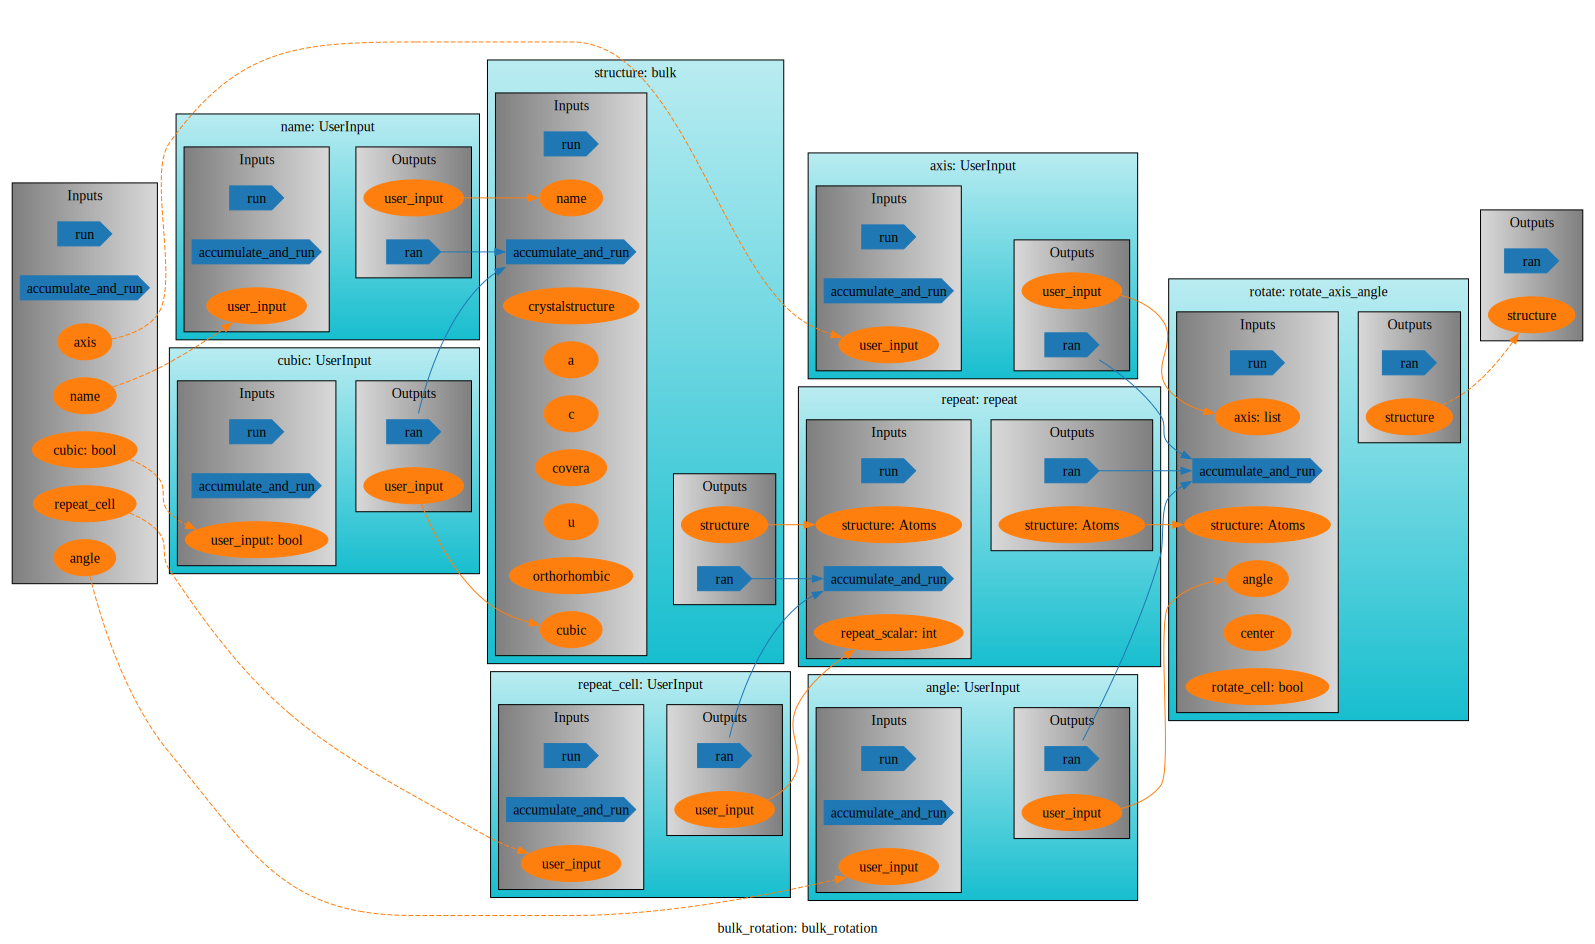

In [6]:
br.draw()

In [7]:
br.inputs.name

In [8]:
br = bulk_rotation(name='Fe')
br.structure.inputs.name = 'Al'
br.inputs.name = 'Al'
br.run()

{'structure': Al: [0. 0. 0.]
 Al: [0.    2.025 2.025]
 Al: [2.025 0.    2.025]
 Al: [2.025 2.025 0.   ]
 Al: [0.   0.   4.05]
 Al: [0.    2.025 6.075]
 Al: [2.025 0.    6.075]
 Al: [2.025 2.025 4.05 ]
 Al: [0.   4.05 0.  ]
 Al: [0.    6.075 2.025]
 Al: [2.025 4.05  2.025]
 Al: [2.025 6.075 0.   ]
 Al: [0.   4.05 4.05]
 Al: [0.    6.075 6.075]
 Al: [2.025 4.05  6.075]
 Al: [2.025 6.075 4.05 ]
 Al: [4.05 0.   0.  ]
 Al: [4.05  2.025 2.025]
 Al: [6.075 0.    2.025]
 Al: [6.075 2.025 0.   ]
 Al: [4.05 0.   4.05]
 Al: [4.05  2.025 6.075]
 Al: [6.075 0.    6.075]
 Al: [6.075 2.025 4.05 ]
 Al: [4.05 4.05 0.  ]
 Al: [4.05  6.075 2.025]
 Al: [6.075 4.05  2.025]
 Al: [6.075 6.075 0.   ]
 Al: [4.05 4.05 4.05]
 Al: [4.05  6.075 6.075]
 Al: [6.075 4.05  6.075]
 Al: [6.075 6.075 4.05 ]
 tags: 
     indices: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 pbc: [ True  True  True]
 cell: 
 Cell([8.1, 8.1, 8.1])}

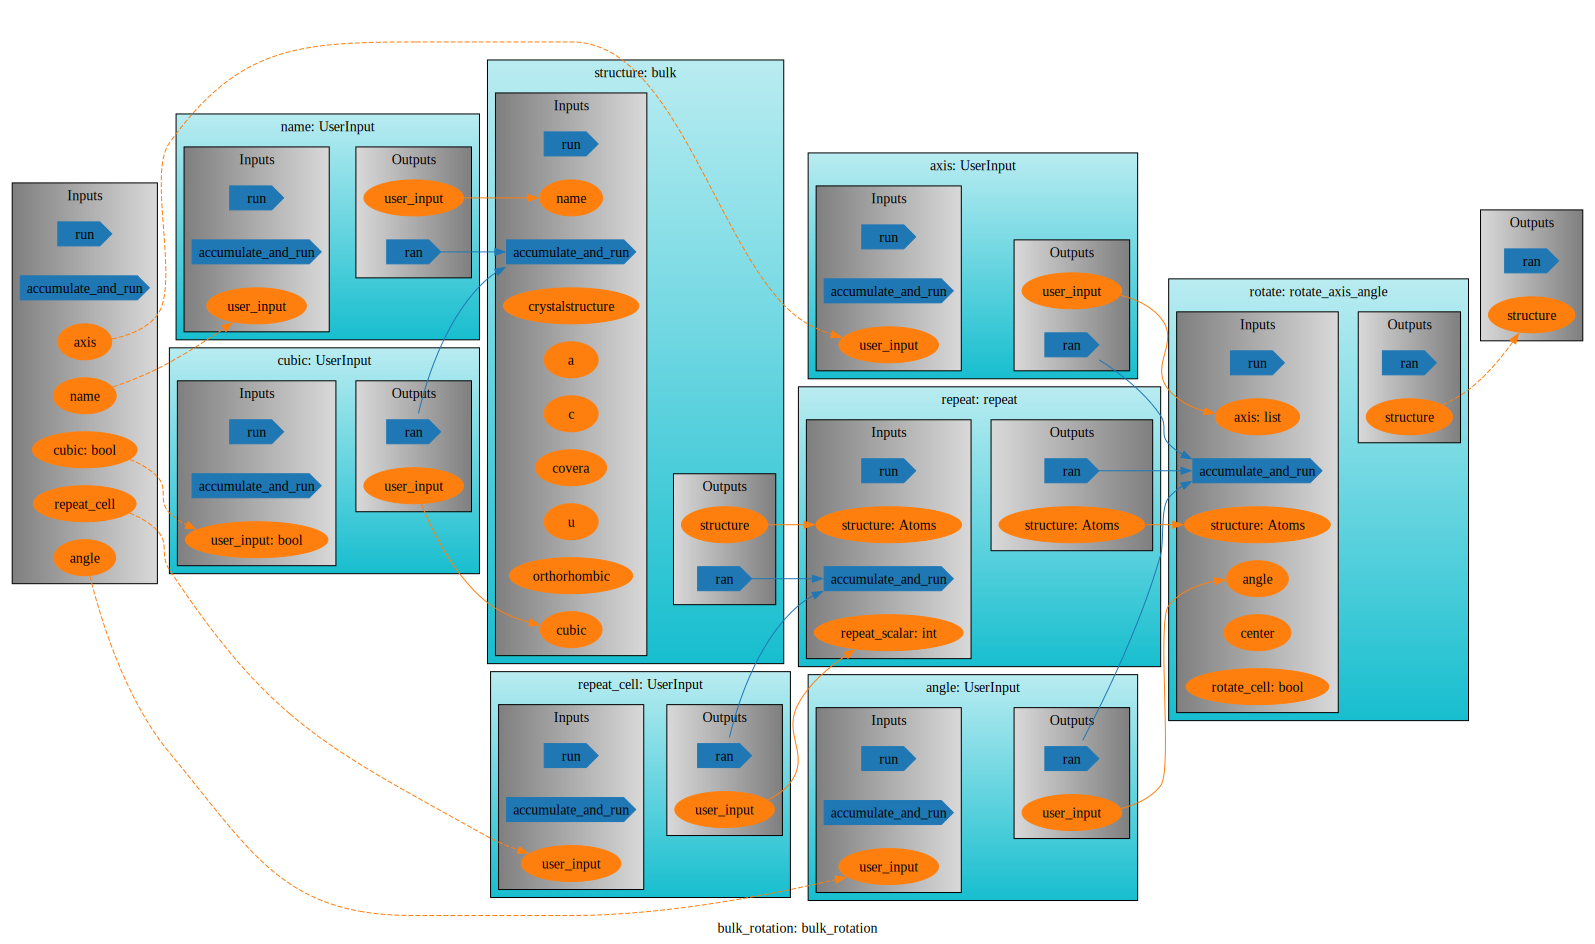

In [9]:
br.draw()

In [10]:
from pyiron_workflow.node_library.atomistic.property.phonons import InputPhonopyGenerateSupercells

### Create phonopy workflow macro

Select input and output parameters in which users may be particularly interested, i.e., over which you want to do a parameter study (input) and the quantities you want to analyse (output)

In [11]:
@Workflow.wrap_as.macro_node(
    "imaginary_modes",
    "total_dos",
    "energy_relaxed",
    "energy_initial",
    "energy_displaced",
)
def run_phonopy(
    wf,
    element: str,
    cell_size: int = 2,
    vacancy_index: int | None = None,
    displacement: float = 0.01,
    max_workers: int = 1
):

    # wf.engine = wf.create.engine.ase.M3GNet()
    wf.engine = wf.create.atomistic.engine.ase.EMT()
    
    wf.structure = wf.create.atomistic.structure.build.cubic_bulk_cell(
        element=element, cell_size=cell_size, vacancy_index=vacancy_index
    )
    # explicit output needed since macro and not single_value_node (we should have also a single_value_macro)
    wf.relaxed_structure = wf.create.atomistic.calculator.ase.minimize(
        atoms=wf.structure.outputs.structure,
        engine=wf.engine,
    )
    
    wf.phonopy_input = wf.create.atomistic.property.phonons.PhonopyParameters(distance=displacement)

    wf.phonopy = wf.create.atomistic.property.phonons.create_phonopy(
        structure=wf.relaxed_structure.outputs.structure,
        parameters=wf.phonopy_input,
        engine=wf.engine,
        max_workers=max_workers,
    )
    # print ('test: ', displacement.run())

    wf.check_consistency = wf.create.atomistic.property.phonons.check_consistency(
        phonopy=wf.phonopy.outputs.phonopy
    )
    wf.total_dos = wf.create.atomistic.property.phonons.get_total_dos(phonopy=wf.phonopy.outputs.phonopy)

    # iterate over all nodes, extract the log_output and store it in hdf5
    # control the amount of output via log_level

    return (
        wf.check_consistency,
        wf.total_dos,
        wf.relaxed_structure.outputs.out.final.energy,
        wf.relaxed_structure.outputs.out.initial.energy,
        wf.phonopy.outputs.out["energies"],
    )

#### Run for a single parameter set

In [12]:
%%time
wf = run_phonopy(element='Al', cell_size=3, vacancy_index=0, displacement=0.1, max_workers=1)
out = wf.run()

energy:  0.8013167095856435 0.7996059979142878
max_workers:  1
CPU times: user 13.8 s, sys: 2.17 s, total: 16 s
Wall time: 5.38 s


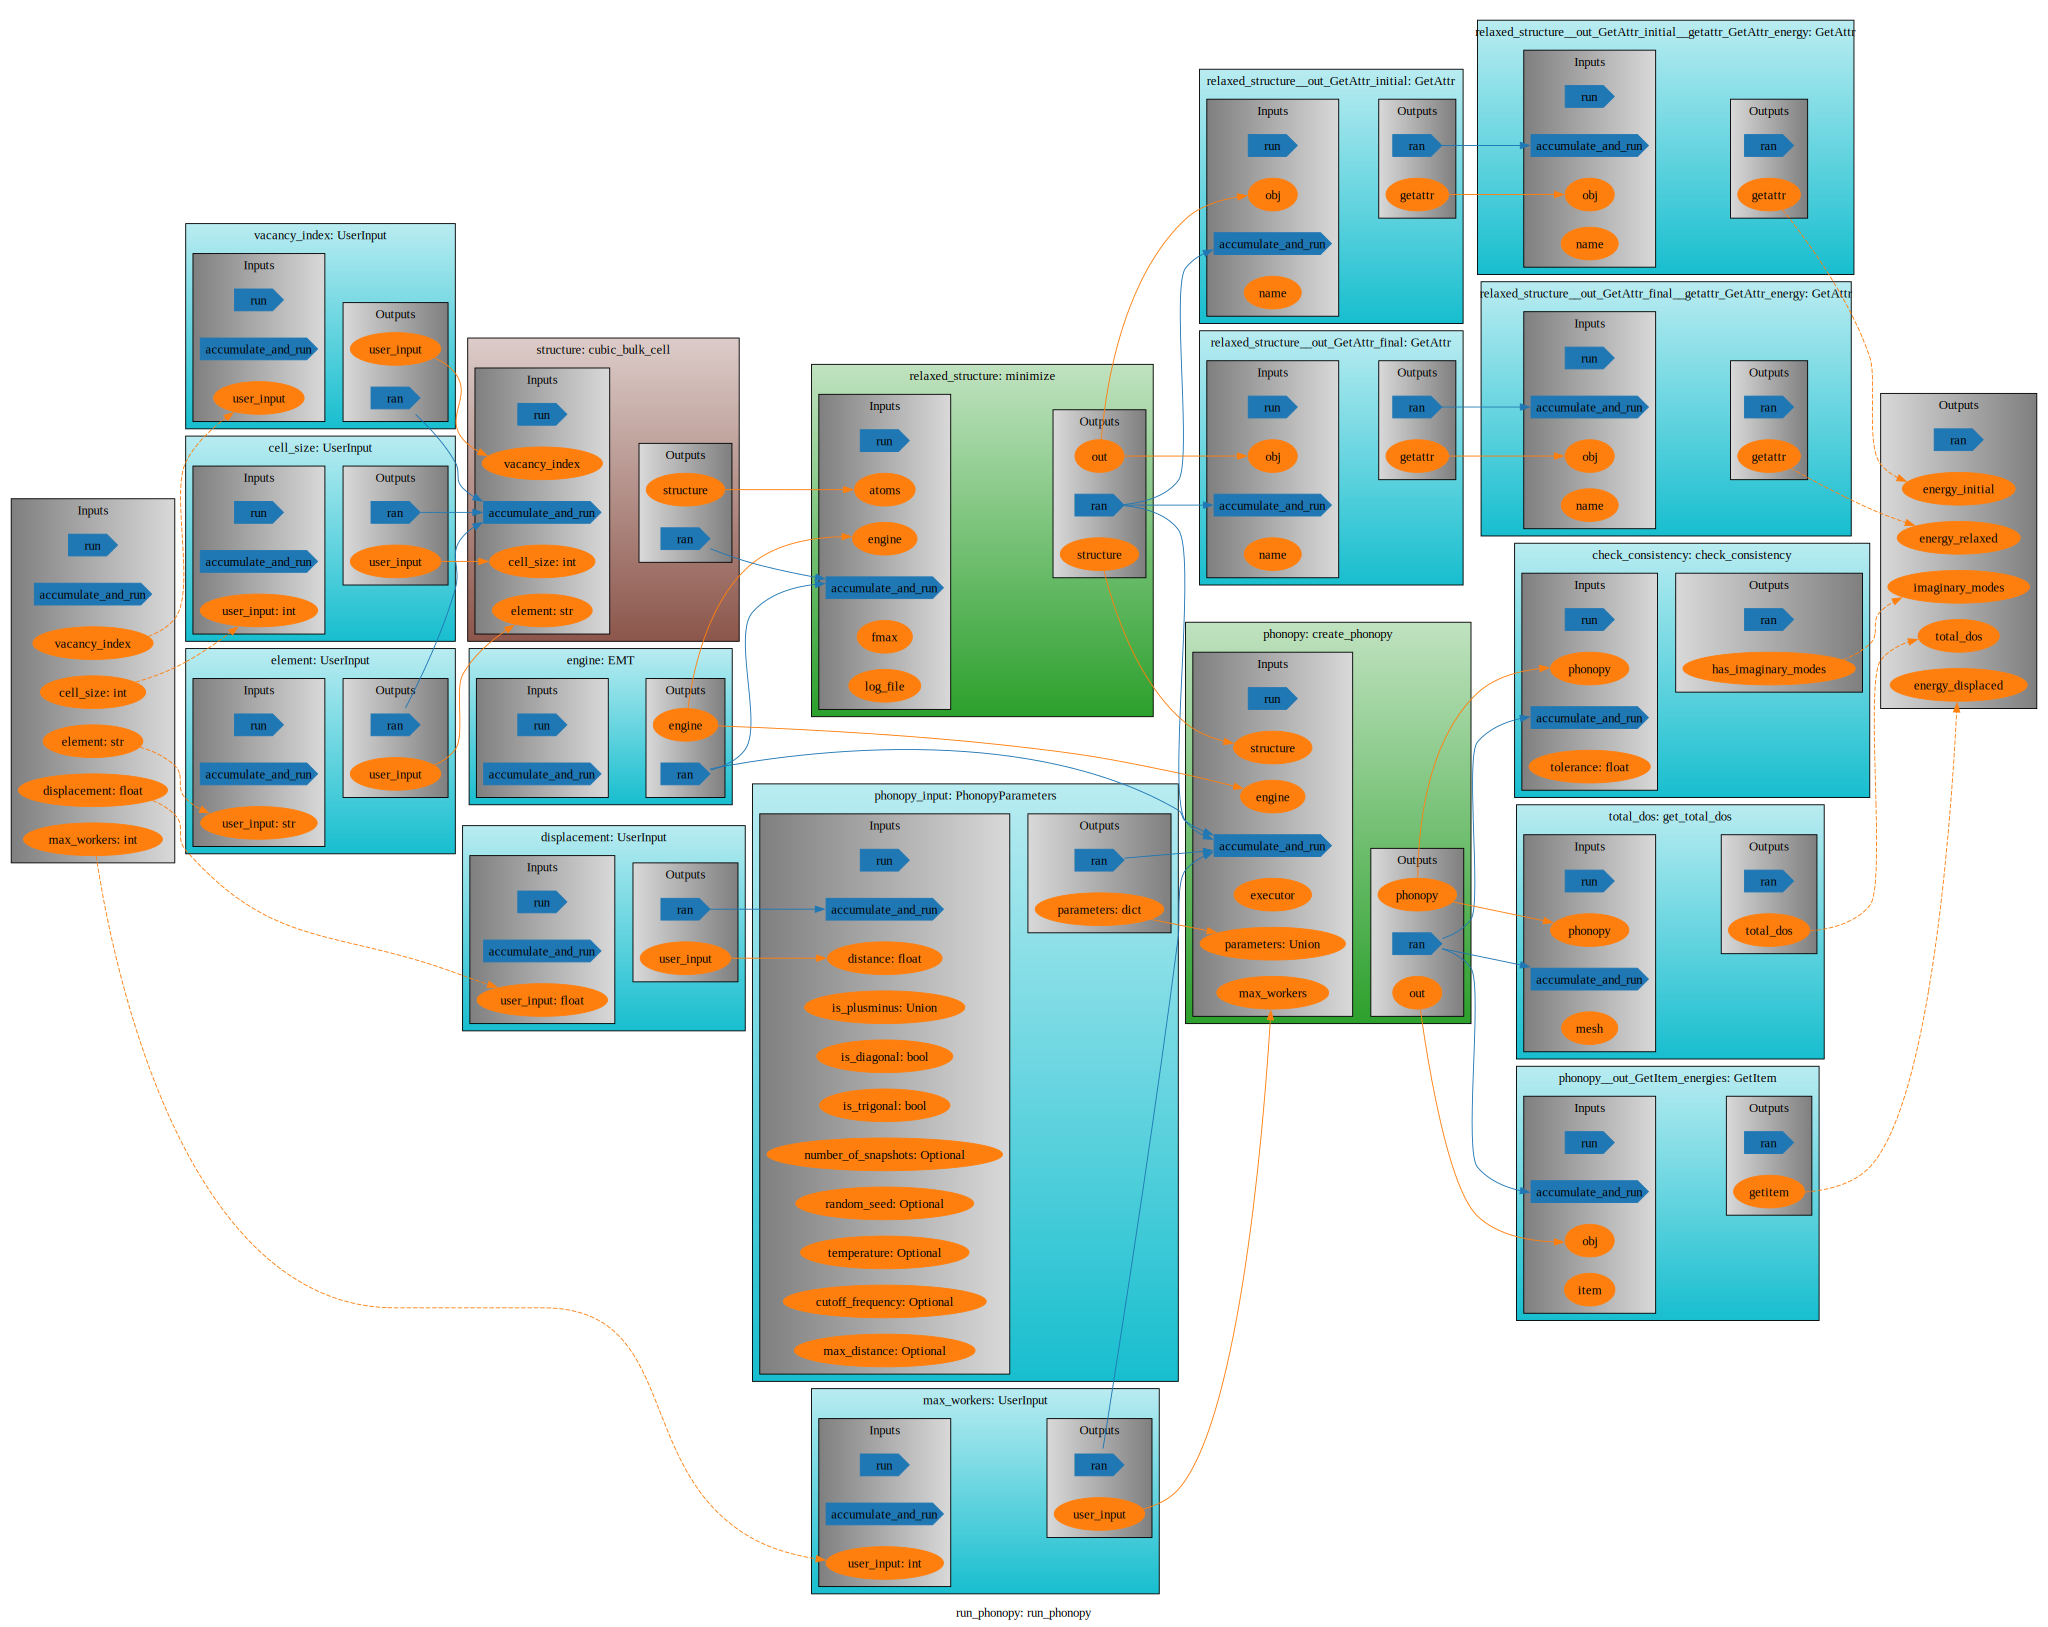

In [13]:
wf.draw()

In [14]:
import pandas as pd

In [15]:
wf.phonopy.outputs.out.value['df']

,atoms,energy_pot,force,stress,structure,atomic_energies,energy,forces
0,"(Atom('Al', [12.220710678118651, 2.08210908380...",None,None,None,None,None,0.816457,"[[-0.23174580883329354, -0.19678867725572524, ..."
1,"(Atom('Al', [12.079289321881344, 1.94068772756...",None,None,None,None,None,0.816327,"[[0.23692289961947186, 0.19206047173841828, -0..."
2,"(Atom('Al', [12.149999999999997, 2.01139840568...",None,None,None,None,None,0.817278,"[[-0.0005872298862959757, -0.02996349715915251..."
3,"(Atom('Al', [12.149999999999997, 2.01139840568...",None,None,None,None,None,0.817907,"[[0.0028026803072459007, 0.032890474969283864,..."
4,"(Atom('Al', [12.149999999999997, 2.01139840568...",None,None,None,None,None,0.816751,"[[0.0007383933558697698, -0.000762530426247583..."
5,"(Atom('Al', [12.149999999999997, 2.01139840568...",None,None,None,None,None,0.818430,"[[-0.0009088635560401473, -0.00237638063938402..."
6,"(Atom('Al', [12.149999999999997, 2.01139840568...",None,None,None,None,None,0.817795,"[[0.03740766557096517, -0.0010937097702614293,..."
7,"(Atom('Al', [12.149999999999997, 2.01139840568...",None,None,None,None,None,0.816850,"[[-0.04661644245198476, -0.001978463773318246,..."
8,"(Atom('Al', [12.149999999999997, 2.01139840568...",None,None,None,None,None,0.818396,"[[0.03786045149966151, -0.0012044959255991111,..."
9,"(Atom('Al', [12.149999999999997, 2.01139840568...",None,None,None,None,None,0.816223,"[[-0.05168042888587365, -0.0018528473275270692..."


#### Run iteratively over several input parameters and construct a pandas table

In [16]:
%%time
df = wf.iter(cell_size=list(range(1,4)), 
             element=['Al'], 
             vacancy_index=[None, 0], 
             displacement=[0.01, 0.1]
            ) #, Cu, Pd, Ag, Pt and Au])

max_workers:  1
energy:  -0.006008190344925168 -0.006008190344925168
max_workers:  1
energy:  -0.006008190344925168 -0.006008190344925168
max_workers:  1
energy:  0.8712882553372374 0.8712882553372374
max_workers:  1
energy:  0.8712882553372374 0.8712882553372374
max_workers:  1
energy:  -0.0480655227588862 -0.0480655227588862
max_workers:  1
energy:  -0.0480655227588862 -0.0480655227588862
max_workers:  1
energy:  0.9186046985116931 0.9179414222257538
max_workers:  1
energy:  0.9186046985116931 0.9179414222257538
max_workers:  1
energy:  -0.16222113933213578 -0.16222113933213578
max_workers:  1
energy:  -0.16222113933213578 -0.16222113933213578
max_workers:  1
energy:  0.8013167095856435 0.7996059979142878
max_workers:  1
energy:  0.8013167095856435 0.7996059979142878
max_workers:  1
CPU times: user 57.3 s, sys: 8.04 s, total: 1min 5s
Wall time: 12 s


In [17]:
df

,cell_size,element,vacancy_index,displacement,imaginary_modes,total_dos,energy_relaxed,energy_initial,energy_displaced
0,1,Al,NaN,0.01,False,frequency_points total_dos 0 ...,-0.006008,-0.006008,"0 -0.005843 Name: energy, dtype: float64"
1,1,Al,NaN,0.10,False,frequency_points total_dos 0 ...,-0.006008,-0.006008,"0 0.010553 Name: energy, dtype: float64"
2,1,Al,0.0,0.01,True,frequency_points total_dos 0 ...,0.871288,0.871288,"0 0.871408 Name: energy, dtype: float64"
3,1,Al,0.0,0.10,True,frequency_points total_dos 0 ...,0.871288,0.871288,"0 0.883371 Name: energy, dtype: float64"
4,2,Al,NaN,0.01,False,frequency_points total_dos 0 -...,-0.048066,-0.048066,"0 -0.047905 Name: energy, dtype: float64"
5,2,Al,NaN,0.10,False,frequency_points total_dos 0 -...,-0.048066,-0.048066,"0 -0.031995 Name: energy, dtype: float64"
6,2,Al,0.0,0.01,True,frequency_points total_dos 0 -...,0.918605,0.917941,0 0.918776 1 0.918736 2 0.918768 3 ...
7,2,Al,0.0,0.10,True,frequency_points total_dos 0 -...,0.918605,0.917941,0 0.933953 1 0.933630 2 0.935058 3 ...
8,3,Al,NaN,0.01,False,frequency_points total_dos 0 -...,-0.162221,-0.162221,"0 -0.162061 Name: energy, dtype: float64"
9,3,Al,NaN,0.10,False,frequency_points total_dos 0 -...,-0.162221,-0.162221,"0 -0.14615 Name: energy, dtype: float64"


### Elasticity

In [18]:
%%time
%config IPCompleter.evaluation='unsafe'

import matplotlib.pylab as plt
from pyiron_workflow.workflow import Workflow

import matplotlib.pylab as plt
import numpy as np

CPU times: user 4.98 ms, sys: 1.71 ms, total: 6.69 ms
Wall time: 1.08 ms


In [19]:
%time
wf = Workflow('phonopy')
wf.register('pyiron_workflow.node_library.atomistic', domain='atomistic')
wf.register('pyiron_workflow.node_library.databases', domain='databases')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


In [20]:
# Get the source data
# from Ref. de Jong et al. https://www.nature.com/articles/sdata20159#MOESM77

import requests

url = 'https://datadryad.org/stash/downloads/file_stream/88988'
destination_file = 'ec.json'

response = requests.get(url)
if response.status_code == 200:
    with open(destination_file, 'wb') as f:
        f.write(response.content)
    print('File downloaded successfully')
else:
    print('Failed to download file:', response.status_code)

ConnectionError: HTTPSConnectionPool(host='datadryad.org', port=443): Max retries exceeded with url: /stash/downloads/file_stream/88988 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x179d46710>: Failed to resolve 'datadryad.org' ([Errno 8] nodename nor servname provided, or not known)"))

In [ ]:
wf = Workflow('elastic')
wf.data = wf.create.databases.elasticity.de_jong()

In [ ]:
%%time
df_data = wf.run()['data__dataframe']

In [ ]:
df_data

In [ ]:
unaries = df_data[df_data.formula.str.len() == 2]
K_Reuss = unaries.K_Reuss.values
K_Voigt = unaries.K_Voigt
structures = unaries.atoms.values

Note: 
- Different symbols/terms for identical physical quantities would be a nice example for application of ontology
- ChatGPT could be used to analyze data (where is agreement good, where not)

In [ ]:
table_M3GNet = Workflow.create.atomistic.structure.calc.volume().iter(structure=structures)  # TODO: load rather than run

In [ ]:
plt.scatter(unaries.volume, table_M3GNet.volume);

In [ ]:
try:
    import matgl
    MATGL_PRESENT = True
except ModuleNotFoundError:
    MATGL_PRESENT = False

In [ ]:
if MATGL_PRESENT:
    import warnings
    warnings.filterwarnings("ignore")

    out = Workflow.create.atomistic.property.elastic.elastic_constants().iter(structure=structures)

In [ ]:
if MATGL_PRESENT:
    x = np.linspace(0, 500, 101)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.scatter(out.BR, unaries.K_Reuss)
    plt.scatter(out.BV, unaries.K_Voigt, c='g', marker = 'x')
    plt.xlabel('$B_{Reuss}$ (M3GNet)')
    plt.ylabel('$B_{Reuss}$ (DFT)')
    plt.title('Bulk Modulus')
    plt.plot(x, x, 'k--');

    plt.subplot(1,2,2)
    x = np.linspace(0, 300, 101)

    plt.scatter(out.GR, unaries.G_Reuss)
    plt.scatter(out.GV, unaries.G_Voigt, c='g', marker = 'x')
    plt.xlabel('$G_{Reuss}$ (M3GNet)')
    plt.ylabel('$G_{Reuss}$ (DFT)')
    plt.title('Shear Modulus')
    plt.plot(x, x, 'k--');

In [ ]:
if MATGL_PRESENT:
    unaries.keys()

### Test universal ML potential

In [ ]:
if MATGL_PRESENT:
    from ase import units
    from ase.build import bulk
    from atomistics.calculators import calc_molecular_dynamics_langevin_with_ase

In [ ]:
if MATGL_PRESENT:
    import matgl
    from matgl.ext.ase import M3GNetCalculator

In [ ]:
if MATGL_PRESENT:

    structure = bulk("Al", cubic=True).repeat([3, 3, 3])
    ase_calculator = M3GNetCalculator(matgl.load_model("M3GNet-MP-2021.2.8-PES"))
    result_dict = calc_molecular_dynamics_langevin_with_ase(
        structure=structure,
        ase_calculator=ase_calculator,
        run=1000,
        thermo=10,
        timestep=1 * units.fs,
        temperature=1000,
        friction=0.002,
    )

In [ ]:
if MATGL_PRESENT:
    result_dict.keys()

In [ ]:
if MATGL_PRESENT:
    plt.plot(result_dict['energy_pot']);

In [ ]:
if MATGL_PRESENT:
    plt.plot(result_dict['positions'][:,:,0]);

In [ ]:
# from pyiron_workflow.node_library.dev_tools import Output
# Does not exist in repo

In [ ]:
# # Example usage:
# def get_energy(arg1, arg2):
#     #print(f"Function 1 called with arguments: {arg1}, {arg2}")
#     return arg1 + arg2

# def function2(arg1, arg2):
#     print(f"Function 2 called with arguments: {arg1}, {arg2}")
#     return f"Hello, {arg1} {arg2}!"

# def function3(arg):
#     print(f"Function 3 called with argument: {arg}")
#     return [i for i in range(arg)]

# def to_dict(func, args=(), kwargs={}):
#     return (func, args, kwargs)

# output = Output(keys_to_run=['energy'])
# print ('keys to run: ', output._keys_to_run)
# output['energy'] = to_dict(get_energy, args=(3, 2))

# output.run()

# # Iterating over keys and values
# for key, value in output.items():
#     print(f"{key}: {value}")

In [ ]:
# 'energy' in output._functions

In [ ]:
# func, args, kwargs = output._functions['energy']

In [ ]:
# func, args, kwargs = to_dict(get_energy, args=(3, 2))

In [ ]:
# func(*args)

In [ ]:
# output._functions['energy']

In [ ]:
# func(*args, **kwargs)

In [ ]:
class LazyDict:
    def __init__(self, **kwargs):
        self._functions = {key: (value['func'], value.get('args', ()), value.get('kwargs', {})) for key, value in kwargs.items()}

    def __getitem__(self, key):
        if key not in self._functions:
            raise KeyError(f"Key '{key}' not found.")
        func, args, kwargs = self._functions[key]
        return func(*args, **kwargs)

    def __setitem__(self, key, value):
        func, args, kwargs = value
        self._functions[key] = (func, args, kwargs)

    def __delitem__(self, key):
        if key in self._functions:
            del self._functions[key]

    def keys(self):
        return list(self._functions.keys())

    def values(self):
        return [self[key] for key in self.keys()]

    def items(self):
        return [(key, self[key]) for key in self.keys()]

    def run(self, keys_to_run):
        for key in keys_to_run:
            if key in self._functions:
                self[key]

# Example usage:
def function1(arg1, arg2):
    print(f"Function 1 called with arguments: {arg1}, {arg2}")
    return arg1 + arg2

def function2(arg1, arg2):
    print(f"Function 2 called with arguments: {arg1}, {arg2}")
    return f"Hello, {arg1} {arg2}!"

def function3(arg):
    print(f"Function 3 called with argument: {arg}")
    return [i for i in range(arg)]

lazy_dict = LazyDict(
    key1={'func': function1, 'args': (3, 4), 'kwargs': {}},
    key2={'func': function2, 'args': ('John', 'Doe'), 'kwargs': {}},
    key3={'func': function3, 'args': (5,), 'kwargs': {}},
)

# Accessing values triggers function evaluation with arguments
print(lazy_dict['key1'])  # Output: Function 1 called with arguments: 3, 4 7
print(lazy_dict['key2'])  # Output: Function 2 called with arguments: John, Doe Hello, John Doe!
print(lazy_dict['key3'])  # Output: Function 3 called with argument: 5 [0, 1, 2, 3, 4]

# Adding a new key-value pair with arguments
#lazy_dict['key4'] = (lambda x, y: x * y, (2, 3), {})
lazy_dict['key4'] = (function1,  (3, 4),  {})
print(lazy_dict['key4'])  # Output: 6

# Run specific functions
lazy_dict.run(['key1', 'key2'])
# Output:
# Function 1 called with arguments: 3, 4
# Function 2 called with arguments: John, Doe

# Iterating over keys and values
for key, value in lazy_dict.items():
    print(f"{key}: {value}")

In [ ]:
from phonopy.api_phonopy import Phonopy
from pyiron_workflow.node_library.dev_tools import wf_data_class

from typing import Optional, Union

In [ ]:
@wf_data_class(doc_func=Phonopy.generate_displacements)
class InputPhonopyGenerateSupercells:
    distance: float = 0.01
    is_plusminus: Union[str, bool] = "auto"
    is_diagonal: bool = True
    is_trigonal: bool = False
    number_of_snapshots: Optional[int] = None
    random_seed: Optional[int] = None
    temperature: Optional[float] = None
    cutoff_frequency: Optional[float] = None
    max_distance: Optional[float] = None    

In [ ]:
par = InputPhonopyGenerateSupercells(max_distance=10)
par['distance'] = 1

In [ ]:
par

In [ ]:
par.distance

In [ ]:
par??

In [ ]:
par.distances=0.2

In [ ]:
par.select(keys_to_store=['distance'])

In [ ]:
def test(**kwargs):
    for a in kwargs.items():
        print (a)

In [ ]:
test(**par.select(keys_to_store=['distance']))

In [ ]:
test(**par)

In [ ]:
from ase import Atoms, build

In [ ]:
Al = build.bulk('Al', cubic=True)
Al.get_positions(wrap=True)

In [ ]:
# Al.get_stress()
# Al needs an ASE calculator object assigned first

In [ ]:
from dataclasses import dataclass, field

@dataclass
class Address:
    street: str = ""
    city: str = ""
    zip_code: str = ""

@dataclass
class Person:
    name: str
    age: int
    address: Address = field(default_factory=Address)

# Example usage
person_with_default_address = Person(name='John Doe', age=30)

# Accessing the default address
print(person_with_default_address.address)

In [ ]:
from dataclasses import dataclass, field

@dataclass
class Address:
    street: str
    city: str
    zip_code: str

@dataclass
class Person:
    name: str
    age: int
    address: Address = field(default_factory=lambda: Address(street='', city='', zip_code=''))

# Example usage
person_with_default_address = Person(name='John Doe', age=30)

# Accessing the default address
print(person_with_default_address.address)

### Pseudocode for output class

In [ ]:
from typing import Optional, Union
from typing import Callable, TypeVar, Any, TypeAlias
from dataclasses import dataclass

import numpy as np

In [ ]:
@dataclass
class VarFunc:
    func: Callable = None
    log_level: int = 0
    unit: str = ''

In [ ]:
@dataclass
class VarType:
    property: TypeVar = None
    log_level: int = 0
    unit: str = ''

In [ ]:
VarFunc(func=np.sin, log_level=2).func

In [ ]:
class toy_job:
    def __init__(self, x=0):
        self.x = x

    def get_energy(self):
        return np.sin(self.x)

    def get_forces(self):
        return np.ones(3)

    @property
    def my_x(self):
        return self.x

In [ ]:
job = toy_job(1)
job.get_energy(), job.get_forces()

In [ ]:
@dataclass
class wfOutput:
    pass

    def keys(self):
        return self.__dict__.keys()

    def __getitem__(self, key):
        return self.__dict__[key]    

    def __call__(self, job):
        out_dict = dict()
        for key in self.keys():
            print (key)
            v = self[key]
            if isinstance(v, VarFunc):
                out_dict[key] = job.__getattribute(job)()
                
        return out_dict       

In [ ]:
import pint
ureg = pint.UnitRegistry()
ureg.angstrom

In [ ]:
# import ase
import pint

@dataclass
class OutputEnergyStatic:
    distance: float = 0.01
    energy: VarFunc = field(
        default_factory=lambda: VarFunc(func=toy_job.get_energy, log_level=0, unit=ureg.eV)
    )
    forces: VarFunc = field(
        default_factory=lambda: VarFunc(func=toy_job.get_forces, log_level=1, unit=ureg.eV/ureg.angstrom)
    )
    prop: VarType = field(default_factory=lambda: VarType(toy_job.my_x, log_level=2))

    def keys(self):
        return self.__dict__.keys()

    def __getitem__(self, key):
        return self.__dict__[key]    

    def __call__(self, job):
        out_dict = dict()
        for key in self.keys():
            print (key)
            v = self[key]
            if isinstance(v, VarFunc):
                out_dict[key] = job.__getattribute(job)()
                
        return out_dict 

In [ ]:
# %%time
df = wf.iter(
    cell_size=list(range(1,2)),   # Or 1,4, but that takes longer
    element=['Al'], 
    vacancy_index=[None, 0], 
    displacement=[0.01, 0.1]
) #, Cu, Pd, Ag, Pt and Au])


In [ ]:
df

In [ ]:
# df.energy_displaced
# Not a column

### Parallel pooling

In [ ]:
@single_value_node('out')
def sleep(time=1, a=None, b=10):
    from time import sleep
    
    sleep(time) 
    return dict(times=time, a2=a, b2=b)

In [ ]:
import inspect

print(inspect.getsource(sleep.node_function))

In [ ]:
%%time
sleep().iter(a=[1,2,3,4,5], max_workers=5, executor=1)

In [ ]:
def sort_list_by_first_element(input_list):
    sorted_list = sorted(input_list, key=lambda x: x[0])
    return sorted_list

In [ ]:
def func(node, **kwargs):
    return node(**kwargs).run()

create list of dictionaries

In [ ]:
def to_list_of_kwargs(**kwargs):
    keys = list(kwargs.keys())
    lists = list(kwargs.values())

    # Get the number of dimensions
    num_dimensions = len(keys)

    # Get the length of each list
    lengths = [len(lst) for lst in lists]

    # Initialize indices
    indices = [0] * num_dimensions

    kwargs_list = []

    # Perform multidimensional for loop
    count = 0
    while indices[0] < lengths[0]:
        # Access the current elements using indices
        current_elements = [lists[i][indices[i]] for i in range(num_dimensions)]

        # Add current_elements as a dictionary
        current_elements_kwarg = dict(zip(keys, current_elements))
        kwargs_list.append(current_elements_kwarg)

        # Update indices for the next iteration
        indices[num_dimensions - 1] += 1

        # Update indices and carry-over if needed
        for i in range(num_dimensions - 1, 0, -1):
            if indices[i] == lengths[i]:
                indices[i] = 0
                indices[i - 1] += 1
                
    return kwargs_list                

In [ ]:
def iter(node, max_workers=5, **kwargs):
    from concurrent.futures import ThreadPoolExecutor, as_completed
    import pandas as pd
    
    futures = []
    future_index_map = {}
    out = []
    out_index = []

    refs = to_list_of_kwargs(**kwargs)
    df_refs = pd.DataFrame(refs)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:  
        for i, ref in enumerate(refs):    
            future = executor.submit(func, node, **ref)
            future_index_map[future] = i
            futures.append(future)
        
        for future in as_completed(futures):
            out.append(future.result())
            out_index.append(future_index_map[future])
        
    df_out = pd.DataFrame(out, index=out_index).sort_index()
    return pd.concat([df_refs, df_out], axis=1)
    

In [ ]:
iter(sleep, max_workers=10, a=[1,2,3,4], b=[1,3])

In [ ]:
type(sleep())()

In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame(dict(a=[1,2,3,4]), index=[2,1,4,3]).sort_index()

In [ ]:
%%time
from pyiron_workflow.node_library.atomistic.engine.lammps import Code

In [ ]:
%config IPCompleter.evaluation='unsafe'

from pyiron_workflow import Workflow
import numpy as np

In [ ]:
wf = Workflow('test')
wf.register('pyiron_workflow.node_library.atomistic', domain='atomistic')

In [ ]:
@Workflow.wrap_as.macro_node('energy_pot')
def energy_at_volume(wf, element='Al', cell_size=2, strain=0):

    wf.structure = wf.create.atomistic.structure.build.cubic_bulk_cell(
        element=element, 
        cubic=True, 
        cell_size=cell_size
    )
    wf.apply_strain = wf.create.atomistic.structure.transform.apply_strain(
        structure=wf.structure.outputs.structure, 
        strain=strain
    )
    wf.engine = wf.create.atomistic.engine.lammps.Code(
        structure=wf.apply_strain
    )  # TODO: find a way to avoid structure=wf.structure !
    wf.calc = wf.create.atomistic.calculator.generic.static(
        structure=wf.apply_strain, 
        engine=wf.engine
    )
    
    return wf.calc.outputs.generic.energy_pot

In [ ]:
df = energy_at_volume(element='Fe').iter(strain=np.linspace(-0.2, 0.2, 11))
df.plot(x='strain', ylabel='Energy (eV)', title='Energy-Volume Curve');

In [ ]:
wf = Workflow('test')
wf.register('pyiron_workflow.node_library.atomistic', domain='atomistic')
wf.structure = wf.create.atomistic.structure.build.bulk('Al')
wf.engine = wf.create.atomistic.engine.lammps.Code(structure=wf.structure)  # TODO: find a way to avoid structure=wf.structure !
wf.calc = wf.create.atomistic.calculator.generic.static(structure=wf.structure, engine=wf.engine)

wf.run()

In [ ]:
wf.calc.outputs.generic.value.energy_pot

In [ ]:
wf.engine.outputs.generic.value

In [ ]:
wf.calc

In [ ]:
wf.calc.outputs.generic.value.energy_pot

In [ ]:
%%time
from pyiron_workflow.node_library.atomistic.calculator.data import InputCalcMinimize, InputCalcStatic

In [ ]:
%%time
from pyiron_atomistics.lammps.base import LammpsControl

In [ ]:
InputCalcMinimize(), InputCalcStatic()

In [ ]:
from pyiron_atomistics.lammps.control import LammpsControl

In [ ]:
# LammpsControl._mode  # We add this attribute in the input control nodes